In [1]:
# Pip install if needed 
# pip install openmeteo-requests

In [2]:
# pip install if needed
# pip install requests-cache retry-requests numpy pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

np.random.seed(42)

In [2]:
weather = pd.read_csv('./data/new-new-york-weather.csv')
weather.shape

C:\Users\graha\AppData\Local\Temp\ipykernel_2664\1420603750.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv('./data/new-new-york-weather.csv')


(368796, 15)

In [3]:
weather.head()

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,uv_index_max,uv_index_clear_sky_max,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
0,2024-01-01 05:00:00+00:00,1.3405,-5.4095,32828.926,28801.018,NaN,NaN,0,0,0,0,15.463246,31.68,42.6,-73.97
1,2024-01-02 05:00:00+00:00,4.0905,-5.6095,32877.49,26970.928,NaN,NaN,0,0,0,0,14.904173,34.56,42.6,-73.97
2,2024-01-03 05:00:00+00:00,3.4405,-2.7595,32930,7048.836,NaN,NaN,0,0,0,0,10.787993,25.56,42.6,-73.97
3,2024-01-04 05:00:00+00:00,2.5904999,-7.2595,32986.375,28849.451,NaN,NaN,0,0,0.07,1,22.725668,52.199997,42.6,-73.97
4,2024-01-05 05:00:00+00:00,1.1405,-7.2595,33046.516,19035.062,NaN,NaN,0,0,0,0,21.142147,47.88,42.6,-73.97


In [9]:
weather = weather.drop(columns = ['uv_index_max','uv_index_clear_sky_max'])

### Drop strings in the dataframe that came from improper appending

In [10]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
5084,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
65675,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
126266,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
187023,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
247614,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
308205,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


In [11]:
weather = weather.drop(weather[weather['daylight_duration'].astype(str).str.contains('day')].index)

In [12]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


### Sort the dataframe by date

In [13]:
weather = weather.sort_values('date')

### Delete the time in all the dates and remove the white space made

In [14]:
weather['date'] = weather['date'].str.replace('05:00:00+00:00', '')
weather['date'] = weather['date'].str.strip()

In [15]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368790 entries, 291050 to 335
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 368790 non-null  object
 1   temperature_2m_max   368790 non-null  object
 2   temperature_2m_min   368790 non-null  object
 3   daylight_duration    368790 non-null  object
 4   sunshine_duration    368788 non-null  object
 5   rain_sum             368790 non-null  object
 6   showers_sum          368790 non-null  object
 7   snowfall_sum         368790 non-null  object
 8   precipitation_hours  368790 non-null  object
 9   wind_speed_10m_max   368790 non-null  object
 10  wind_gusts_10m_max   368790 non-null  object
 11  latitude             368790 non-null  object
 12  longitude            368790 non-null  object
dtypes: object(13)
memory usage: 39.4+ MB


In [17]:
weather[['temperature_2m_max','temperature_2m_min',"daylight_duration","sunshine_duration","rain_sum",'showers_sum',
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]] = weather[['temperature_2m_max','temperature_2m_min',"daylight_duration","sunshine_duration","rain_sum",'showers_sum',
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]].apply(pd.to_numeric)

In [18]:
weather['precipitation_total'] = weather['rain_sum'] + weather['snowfall_sum'] 
weather['location'] = list(zip(weather['latitude'],weather['longitude']))

In [19]:
# Group by 'location'
grouped = weather.groupby('location')

# Drop duplicates based on 'date' for each group
weather = pd.concat([group.drop_duplicates(subset=['date']) for _, group in grouped], ignore_index=True)

# Display the first few rows of the cleaned DataFrame
weather.shape

(368790, 15)

In [20]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368790 entries, 0 to 368789
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 368790 non-null  object 
 1   temperature_2m_max   368790 non-null  float64
 2   temperature_2m_min   368790 non-null  float64
 3   daylight_duration    368790 non-null  float64
 4   sunshine_duration    368788 non-null  float64
 5   rain_sum             368790 non-null  float64
 6   showers_sum          368790 non-null  float64
 7   snowfall_sum         368790 non-null  float64
 8   precipitation_hours  368790 non-null  float64
 9   wind_speed_10m_max   368790 non-null  float64
 10  wind_gusts_10m_max   368790 non-null  float64
 11  latitude             368790 non-null  float64
 12  longitude            368790 non-null  float64
 13  precipitation_total  368790 non-null  float64
 14  location             368790 non-null  object 
dtypes: float64(13), o

In [21]:
weather.isnull().sum()

date                   0
temperature_2m_max     0
temperature_2m_min     0
daylight_duration      0
sunshine_duration      2
rain_sum               0
showers_sum            0
snowfall_sum           0
precipitation_hours    0
wind_speed_10m_max     0
wind_gusts_10m_max     0
latitude               0
longitude              0
precipitation_total    0
location               0
dtype: int64

In [24]:
weather.dropna(inplace = True)

Make a clustering model with everything 

In [40]:
weather_km = weather.copy()
weather_km['date'] = pd.to_datetime(weather_km['date'])
df_2020 = weather_km[weather_km['date'].dt.year == 2020]
X = df_2020.drop(columns = ['date','location','rain_sum','snowfall_sum'])

pipe_km = Pipeline([
    ('sc', StandardScaler()),
    ('pca',PCA(n_components=5)),
    ('km', KMeans(n_clusters=2))
])

pipe_km.fit(X)


cluster_centers = pipe_km.named_steps['km'].cluster_centers_
centroids_pca = pipe_km.named_steps['pca'].inverse_transform(cluster_centers)
centroids = pipe_km.named_steps['sc'].inverse_transform(centroids_pca)


centroids_df = pd.DataFrame(
    centroids,
    columns=X.columns
)

C:\Users\graha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [41]:
# This showed that 5 components explaied about 91% of the variance for PCA so that was changed in the pipeline
var_exp = pipe_km['pca'].explained_variance_ratio_
np.round(var_exp[:8],3)

array([0.438, 0.265, 0.173, 0.052, 0.043])

In [42]:
# commenting out since it takes about 5 min to run 
X_scaled_pca = pipe_km.named_steps['pca'].transform(X)
cluster_labels = pipe_km.named_steps['km'].labels_
silhouette_score(X_scaled_pca, cluster_labels)

# got a score of 0.29 since it goes from -1 to 1 this is a pretty bad score when using PCA n_components 5 and KMeans(n_clusters = 3)

C:\Users\graha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


0.4400710908002623

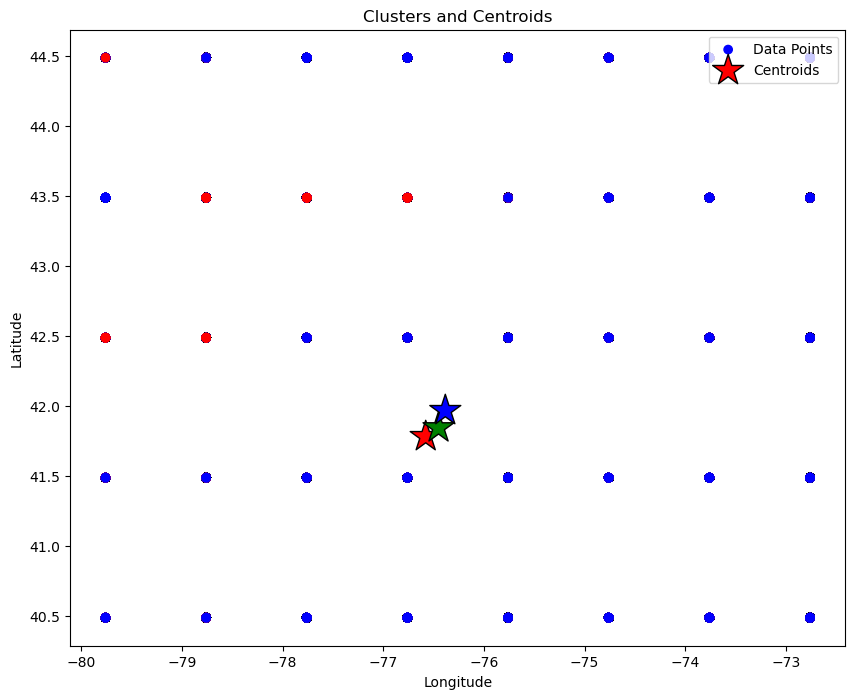

In [17]:
# Define figure size
plt.figure(figsize=(10, 8))

# Map colors for different clusters
colors = ["red", "green", "blue"]
weather_km['color'] = weather_km['cluster'].map(lambda p: colors[p])

# Plot points (spatial data)
plt.scatter(
    weather_km['longitude'], weather_km['latitude'], 
    c=weather_km['color'], 
    label='Data Points'
)

# Plot centroids
plt.scatter(
    centroids_df['longitude'], centroids_df['latitude'], 
    marker="*", 
    c=colors, 
    s=550, 
    edgecolor="k", 
    label='Centroids'
)

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters and Centroids")
plt.legend()
plt.show()



